In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels as sm
import statsmodels.api as sma
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [85]:
df = pd.read_csv('default_credit.csv', index_col=0)
df.head()

,default,student,balance,income
index,,,,
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


## Variables

* default: Variable binaria. Registra si el cliente entró en morosidad o no.
* income: Ingreso promedio declarado por el cliente.
* balance: Total de saldo en la cuenta de crédito.
* student: Variable binaria. Registra si el cliente es estudiante o no.

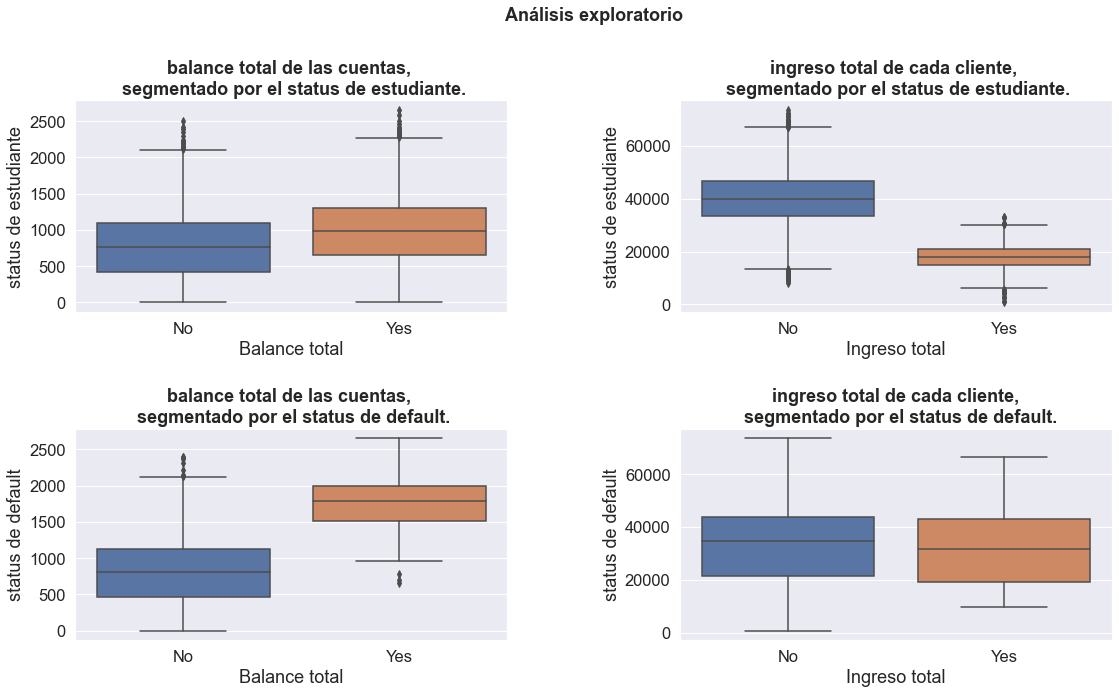

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Análisis exploratorio',  fontweight="bold", size=18)
ax = plt.gca()
titulos = [
    'balance total de las cuentas, \n segmentado por el status de estudiante.',
    'ingreso total de cada cliente, \n segmentado por el status de estudiante.',
    'balance total de las cuentas, \n segmentado por el status de default.',
    'ingreso total de cada cliente,\n  segmentado por el status de default.'
    ]
y_labels = [
    'Balance total',
    'Ingreso total',
    'Balance total',
    'Ingreso total',
]

x_labels = [
    'status de estudiante',
    'status de estudiante',
    'status de default',
    'status de default',
]

sns.set(font_scale = 1.5)
sns.boxplot(y='balance', x='student', data=df, ax=axes[0, 0])
sns.boxplot(ax = axes[0, 1], y='income', x='student', data=df)
sns.boxplot(ax = axes[1, 0], y='balance', x='default', data=df)
sns.boxplot(ax = axes[1 ,1], y='income', x='default', data=df)

for ax, titulo, x_l, y_l in zip(axes.reshape(-1),titulos, x_labels, y_labels):
    ax.set_title(titulo, fontweight="bold", size=18)
    ax.set_ylabel(x_l, fontsize=18)
    ax.set_xlabel(y_l, fontsize=18) 
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.85,
                    wspace=0.4,
                    hspace=0.55)
plt.show()


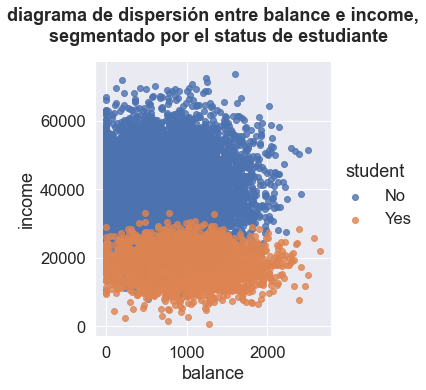

In [87]:
lm = sns.lmplot(x='balance', y='income', data=df, fit_reg=False, hue='student');
lm.fig.gca().set_title('diagrama de dispersión entre balance e income,\n  segmentado por el status de estudiante', fontweight="bold", size=18, pad=20);

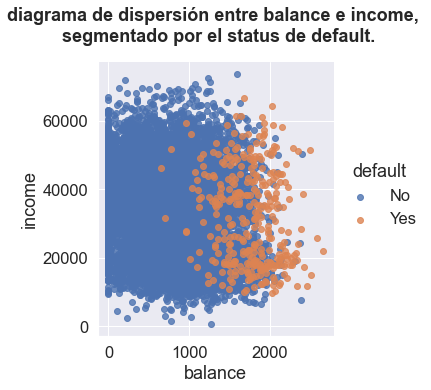

In [88]:
lm = sns.lmplot(x='balance', y='income', data=df, fit_reg=False, hue='default');
lm.fig.gca().set_title('diagrama de dispersión entre balance e income, \n segmentado por el status de default.',fontweight="bold", size=18, pad=20);

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


In [90]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
target = ['default']
predictors = ['student', 'balance', 'income']
drop_columns = ['income']
categorical = ['student','default']
categorical_wo_target = [elt for elt in categorical if elt not in target]
predictors = [elt for elt in predictors if elt not in drop_columns]

df_dc = df.drop(columns = drop_columns)


ohe = SklearnTransformerWrapper(OrdinalEncoder(), variables=categorical)
sc = SklearnTransformerWrapper(StandardScaler(), variables=predictors)

df_ohe = ohe.fit_transform(df_dc)

x = df_ohe.drop(columns=target)
y = df_ohe[target[0]]


x_sc = sc.fit_transform(x)
X = sma.add_constant(x_sc)

model = sma.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.078584
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Mon, 25 Jul 2022   Pseudo R-squ.:                  0.4619
Time:                        01:28:01   Log-Likelihood:                -785.84
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                1.189e-293
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1665      0.190    -32.447      0.000      -6.539      -5.794
student       -0.3258      0.067     -4.846      0.000      -0.458      -0.194
balance        2.7755      0.112     24.748      0.000       2.556       2.995
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [91]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X)
accuracy_score(y, y_pred>0.5)

0.9733

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.metrics import mean_squared_error, recall_score, f1_score, precision_score, confusion_matrix, classification_report, plot_roc_curve, RocCurveDisplay, auc, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pipe = Pipeline(steps=[
    ('ohe', SklearnTransformerWrapper(OrdinalEncoder(), variables=categorical_wo_target)),
    ('sc', SklearnTransformerWrapper(StandardScaler(), variables=predictors)),
    ('lr', LogisticRegression())
    ])

pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print(f'RMSE Entrenamiento: {mean_squared_error(y_train, y_pred_train, squared=False)}')
print(f'RMSE Validación: {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE Entrenamiento: 0.1620760831104266
RMSE Validación: 0.16422453217986943


In [93]:
data1 = pipe.predict_proba(X_test)
data2 = np.array([pipe.predict(X_test)]).T
data3 = np.array([y_test]).T
data = np.append(data1, data2, axis=1)
data = np.append(data, data3, axis=1)
pd.DataFrame(data, columns = ['P(no default)','P(default)', 'Predicted', 'Real'])

,P(no default),P(default),Predicted,Real
0,0.929263,0.070737,0.0,0.0
1,0.998412,0.001588,0.0,0.0
2,0.999982,0.000018,0.0,0.0
3,0.999966,0.000034,0.0,0.0
4,0.953788,0.046212,0.0,0.0
...,...,...,...,...
3295,0.992990,0.007010,0.0,0.0
3296,0.977084,0.022916,0.0,0.0
3297,0.999700,0.000300,0.0,0.0
3298,0.276823,0.723177,1.0,0.0


In [94]:
def reporte(y_true, y_pred):
    print(f'Precision: {precision_score(y_true, y_pred)}')
    print(f'Recall: {recall_score(y_true, y_pred)}')
    print(f'F1: {f1_score(y_true, y_pred)}')
    print(f'Confusion matrix: \n{  (y_true, y_pred)}')
    print(f'Classification report: \n{classification_report(y_true, y_pred)}')

reporte(y_test, y_pred)

Precision: 0.7333333333333333
Recall: 0.3
F1: 0.4258064516129032
Confusion matrix: 
(index
6253    0.0
4685    0.0
1732    0.0
4743    0.0
4522    0.0
       ... 
1745    0.0
9755    0.0
6095    0.0
8782    0.0
9402    0.0
Name: default, Length: 3300, dtype: float64, array([0., 0., 0., ..., 0., 1., 0.]))
Classification report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3190
         1.0       0.73      0.30      0.43       110

    accuracy                           0.97      3300
   macro avg       0.85      0.65      0.71      3300
weighted avg       0.97      0.97      0.97      3300



c:\ProgramData\Anaconda3\envs\dl\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


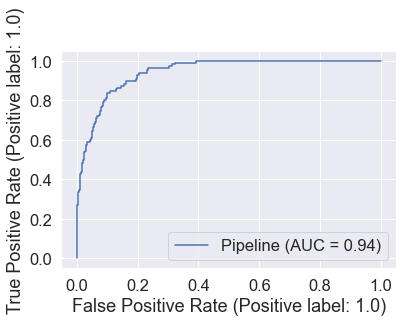

In [111]:
plot_roc_curve(pipe, X_test, y_test)


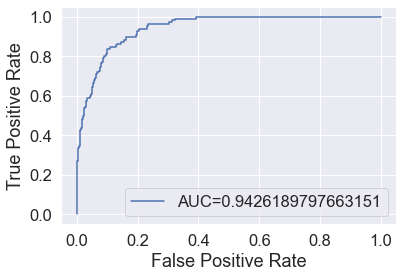

In [119]:
#define metrics
y_pred_proba = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()